In [1]:
import jax

jax.config.update("jax_enable_x64", True)

import flax
import jax.numpy as jnp
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import numpyro
import numpyro.distributions as dist
import optax
from flax import linen as nn
from numpyro.contrib.module import random_flax_module
from numpyro.infer import SVI, Predictive, Trace_ELBO
from numpyro.infer.autoguide import AutoDelta, AutoNormal

%matplotlib inline

In [59]:
L = 1  # number of labels
T = 2  # number of latents
F = 32  # number of flux values
N = 1024  # number of stars

rng = np.random.default_rng(seed=8675209)

# alpha = rng.normal(0., label_scales, size=(M, K))
alpha = np.zeros((L, T))
alpha[0, 0] = 1.

beta = rng.normal(size=(F, T))

def make_data(N, rng):
    # label_scales = 10 ** rng.uniform(-2, 2, size=(M, 1))
    label_scales = jnp.ones((L, 1))

    zeta = rng.normal(size=(N, T))

    labels = (alpha @ zeta.T).T
    fluxs = (beta @ zeta.T).T

    label_err = rng.uniform(0.01, 0.1, size=labels.shape) * label_scales.T
    flux_err = rng.uniform(0.01, 0.1, size=fluxs.shape)

    obs = {
        "label": rng.normal(labels, label_err),
        "label_err": label_err,
        "flux": rng.normal(fluxs, flux_err),
        "flux_err": flux_err,
    }
    truth = {
        "label": labels,
        "flux": fluxs,
        "alpha": alpha,
        "beta": beta,
        "zeta": zeta,
    }

    return obs, truth

data, data_true = make_data(N, rng=rng)
test_data, test_data_true = make_data(N, rng=rng)

In [60]:
class Paton(nn.Module):
    n_labels: int
    n_latents: int
    n_hidden: int
    n_flux: int

    def setup(self):
        self.labels = nn.Dense(self.n_labels)
        self.hidden = nn.Dense(self.n_hidden)
        self.flux = nn.Dense(self.n_flux)

    def __call__(self, z):
        # Linear transformation of the latents:
        labels = self.labels(z)

        # One hidden layer, but nonlinear in the latents:
        hidden = jax.nn.sigmoid(self.hidden(z))
        flux = jax.nn.sigmoid(self.flux(hidden))

        return labels, flux

In [61]:
paton_model = Paton(
    n_labels=L,
    n_latents=T,
    n_hidden=F // 4,
    n_flux=F,
)

Test evaluating the model:

In [62]:
N_eval = 10

key = jax.random.PRNGKey(42322)
tmp_z = jax.random.normal(key, (N_eval, T))  # Dummy input data
tmp_params = paton_model.init(key, tmp_z)
paton_model.apply(tmp_params, tmp_z)

(Array([[-0.32762592],
        [ 0.11948835],
        [ 0.43187933],
        [ 0.40999649],
        [-0.17919745],
        [-0.57065288],
        [ 0.29609572],
        [ 0.22782573],
        [-0.25779581],
        [-0.24877652]], dtype=float64),
 Array([[0.6545471 , 0.51445112, 0.51385865, 0.39607717, 0.63862348,
         0.39843759, 0.53148446, 0.38100866, 0.57507411, 0.48726575,
         0.46504918, 0.54360741, 0.5427857 , 0.58011951, 0.74078684,
         0.69076061, 0.79007498, 0.47762555, 0.39455604, 0.49155418,
         0.55692525, 0.48243966, 0.61725617, 0.60491133, 0.54610604,
         0.33194662, 0.58019693, 0.67678219, 0.46807014, 0.5084068 ,
         0.31415774, 0.38014919],
        [0.71064399, 0.47496055, 0.57471139, 0.54377684, 0.63546148,
         0.32203817, 0.63238645, 0.32712087, 0.48047276, 0.65016661,
         0.56394006, 0.42952219, 0.57109037, 0.4378643 , 0.79240858,
         0.57817392, 0.87006325, 0.50858552, 0.21882965, 0.57092325,
         0.67635599, 0.470951

How many parameters does the model have?

In [63]:
np.concatenate(
    [x.ravel() for x in jax.tree_util.tree_flatten(tmp_params["params"])[0]]
).shape

(315,)

In [64]:
def numpyro_model(paton_model, n_stars, data):
    paton = random_flax_module(
        "paton",
        paton_model,
        prior={
            "flux.bias": dist.Cauchy(scale=0.1),
            "flux.kernel": dist.Normal(),
            "hidden.bias": dist.Cauchy(scale=0.1),
            "hidden.kernel": dist.Normal(),
            "labels.bias": dist.Cauchy(scale=0.1),
            "labels.kernel": dist.Normal(),
        },
        # Or, if using the same prior for all parameters, we can do:
        # prior=dist.Normal(),
        input_shape=(n_stars, paton_model.n_latents),
    )

    zeta = numpyro.sample(
        "zeta", dist.Normal(), sample_shape=(n_stars, paton_model.n_latents),
    )
    # L1 regularization on the latents
    numpyro.factor("zeta_L1", -jnp.abs(zeta[:, paton_model.n_labels:] / 0.1).sum())

    a_label = numpyro.sample("a_label", dist.Normal())
    b_label = numpyro.sample("b_label", dist.Normal())

    a_flux = numpyro.sample("a_flux", dist.Normal())
    b_flux = numpyro.sample("b_flux", dist.Normal())

    label_unscaled, flux_unscaled = paton(zeta)
    model_label = a_label * label_unscaled + b_label
    model_flux = a_flux * flux_unscaled + b_flux
    numpyro.sample(
        "label", dist.Normal(model_label, data["label_err"]), obs=data["label"]
    )
    numpyro.sample(
        "flux", dist.Normal(model_flux, data["flux_err"]), obs=data["flux"]
    )

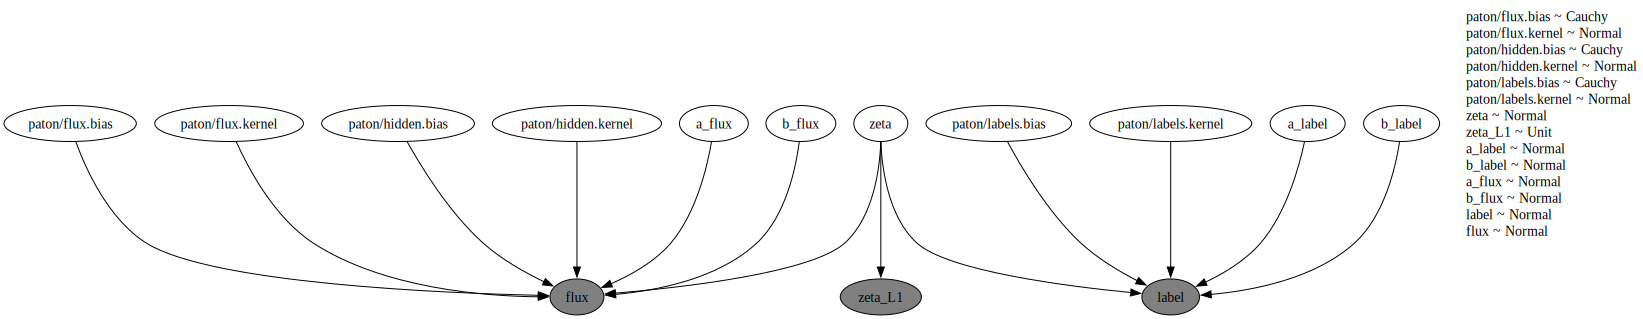

In [65]:
model_kwargs = {
    "paton_model": paton_model,
    "n_stars": data["flux"].shape[0],
    "data": data
}

test_model_kwargs = {
    "paton_model": paton_model,
    "n_stars": test_data["flux"].shape[0],
    "data": test_data
}

numpyro.render_model(
    model=numpyro_model,
    model_kwargs=model_kwargs,
    render_distributions=True,
    render_params=True,
)

Optimize to get MAP parameters:

In [66]:
rng_key = jax.random.PRNGKey(112358)

optimizer = numpyro.optim.Adam(1e-2)
guide = AutoDelta(numpyro_model)
svi = SVI(numpyro_model, guide, optimizer, Trace_ELBO())
svi_results = svi.run(rng_key, 100_000, **model_kwargs)
MAP_params = svi_results.params

100%|██████████| 100000/100000 [00:44<00:00, 2253.75it/s, init loss: 32222733.5194, avg. loss [95001-100000]: 146502.0683]


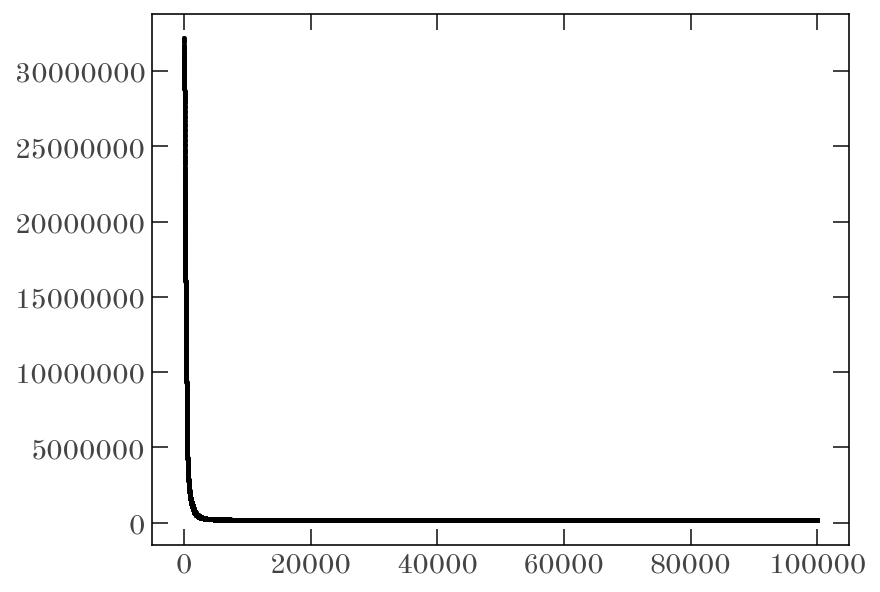

In [67]:
plt.figure(figsize=(6, 4))
plt.plot(svi_results.losses)

In [68]:
thing = Predictive(
    model=numpyro_model, guide=guide, params=MAP_params, num_samples=1
)
MAP_pp = thing(rng_key, **model_kwargs)

thing = Predictive(guide, params=MAP_params, num_samples=1)
MAP_p = thing(rng_key, **model_kwargs)

In [69]:
print(MAP_p["a_label"][0], MAP_p["b_label"][0])
print(MAP_p["a_flux"][0], MAP_p["b_flux"][0])

-2.253841624595315 0.3606782236445984
15.501078574568155 -5.284524191791799


In [70]:
MAP_p["paton/labels.kernel"]

Array([[[0.96067949],
        [2.4186041 ]]], dtype=float64)

In [71]:
MAP_paton_params = {
    "params": {
        "labels": {
            "kernel": MAP_p["paton/labels.kernel"][0],
            "bias": MAP_p["paton/labels.bias"][0]
        },
        "hidden": {
            "kernel": MAP_p["paton/hidden.kernel"][0],
            "bias": MAP_p["paton/hidden.bias"][0]
        },
        "flux": {
            "kernel": MAP_p["paton/flux.kernel"][0],
            "bias": MAP_p["paton/flux.bias"][0]
        }
    }
}
MAP_label, MAP_flux = paton_model.apply(MAP_paton_params, MAP_p["zeta"])
MAP_label = MAP_p["a_label"][0] * MAP_label[0] + MAP_p["b_label"][0]
MAP_flux = MAP_p["a_flux"][0] * MAP_flux[0] + MAP_p["b_flux"][0]

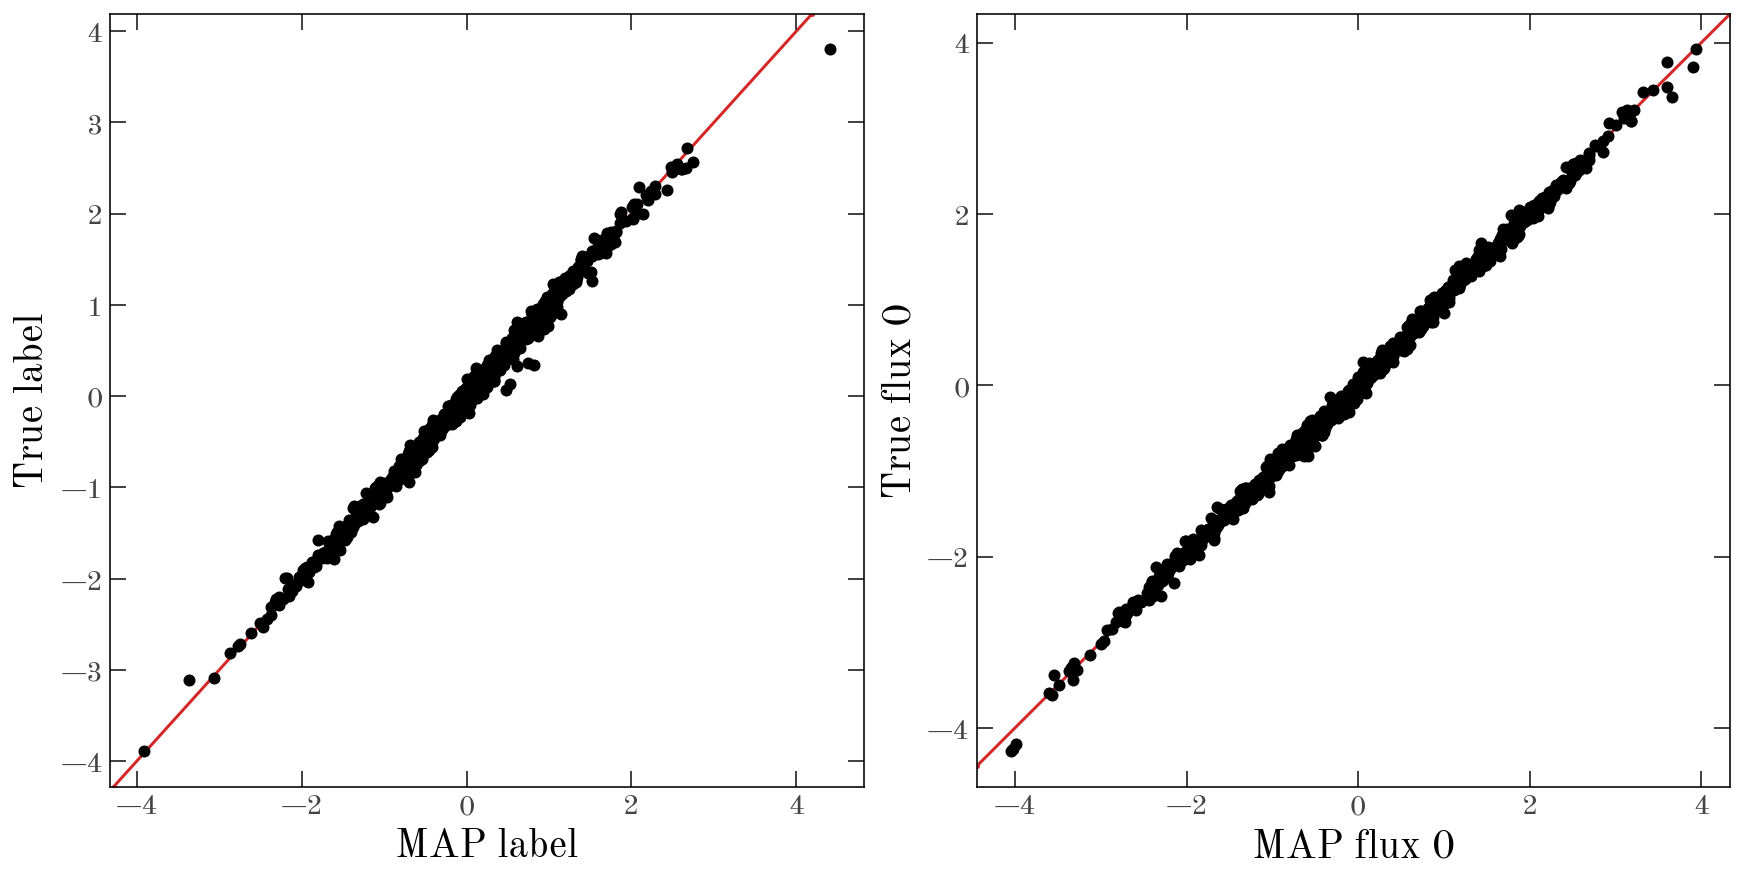

In [72]:
fig, axes = plt.subplots(1, 2, figsize=(12, 6))
axes[0].scatter(
    MAP_label[:, 0],
    data["label"][:, 0]
)
axes[0].set_xlabel("MAP label")
axes[0].set_ylabel("True label")
axes[0].axline([0, 0], slope=1, color="tab:red", zorder=-100)

axes[1].scatter(
    MAP_flux[:, 0],
    data["flux"][:, 0]
)
axes[1].set_xlabel("MAP flux 0")
axes[1].set_ylabel("True flux 0")
axes[1].axline([0, 0], slope=1, color="tab:red", zorder=-100)

In [73]:
np.sum((MAP_label[:, 0] - data["label"][:, 0])**2)

Array(5.54992843, dtype=float64)

In [74]:
np.sum((MAP_flux[:, 0] - data["flux"][:, 0])**2)

Array(4.63164736, dtype=float64)

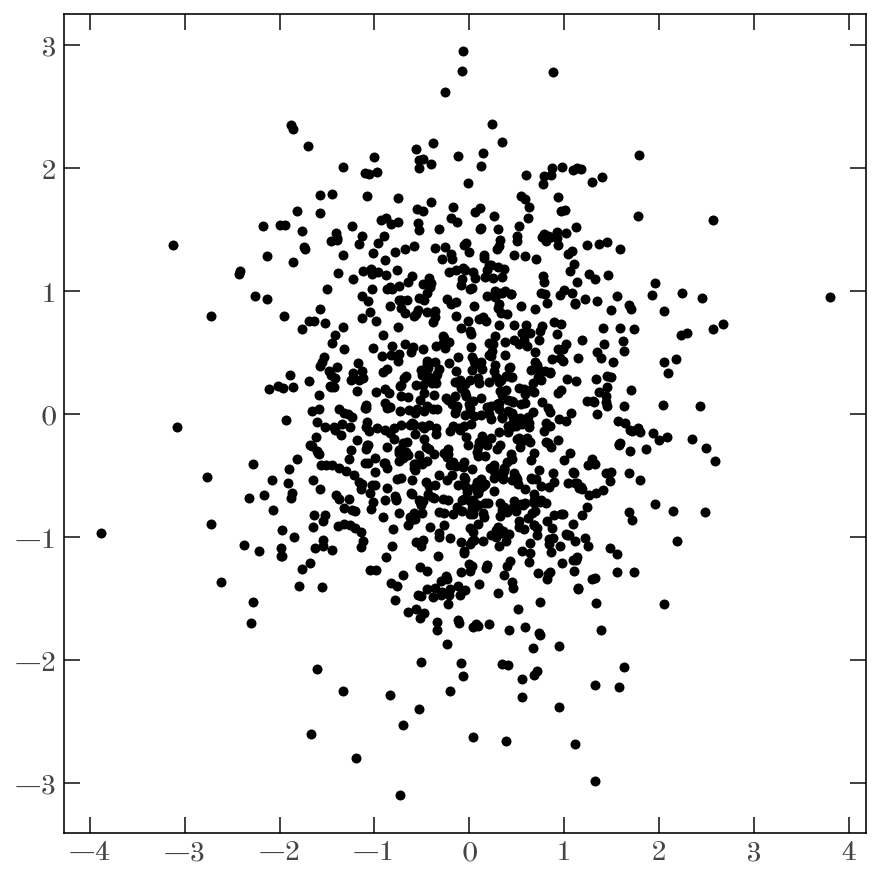

In [75]:
plt.plot(
    data_true["zeta"][:, 0],
    data_true["zeta"][:, 1],
    ls="none", marker="o"
);

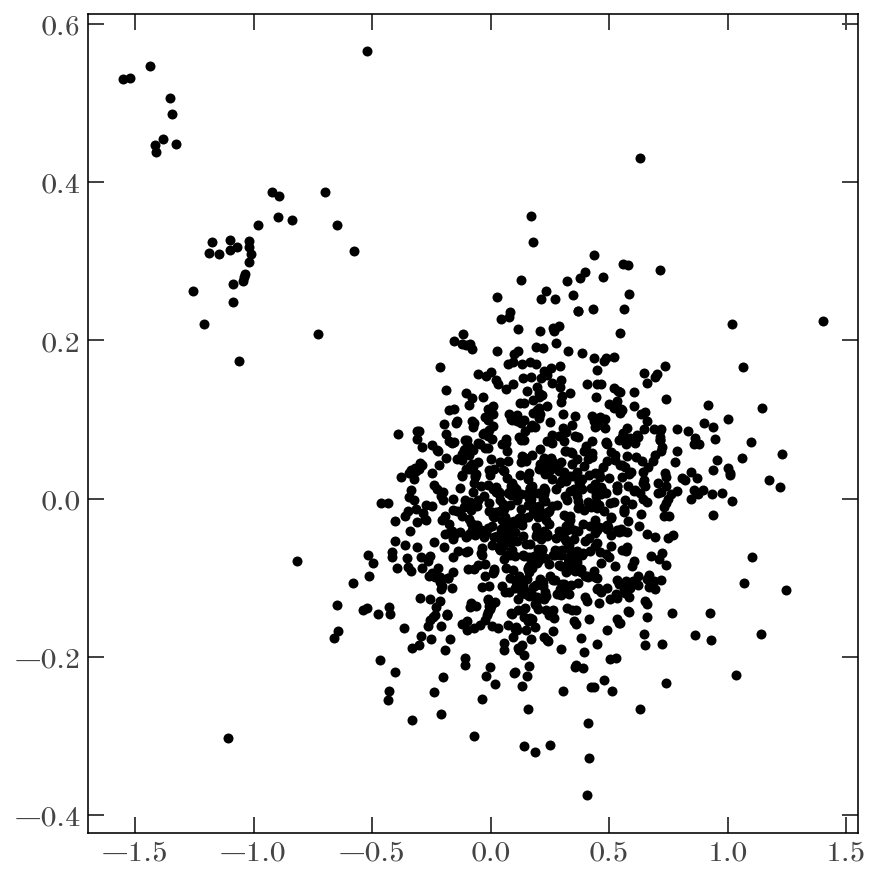

In [76]:
plt.plot(
    MAP_p["zeta"][0, :, 0],
    MAP_p["zeta"][0, :, 1],
    ls="none", marker="o"
);

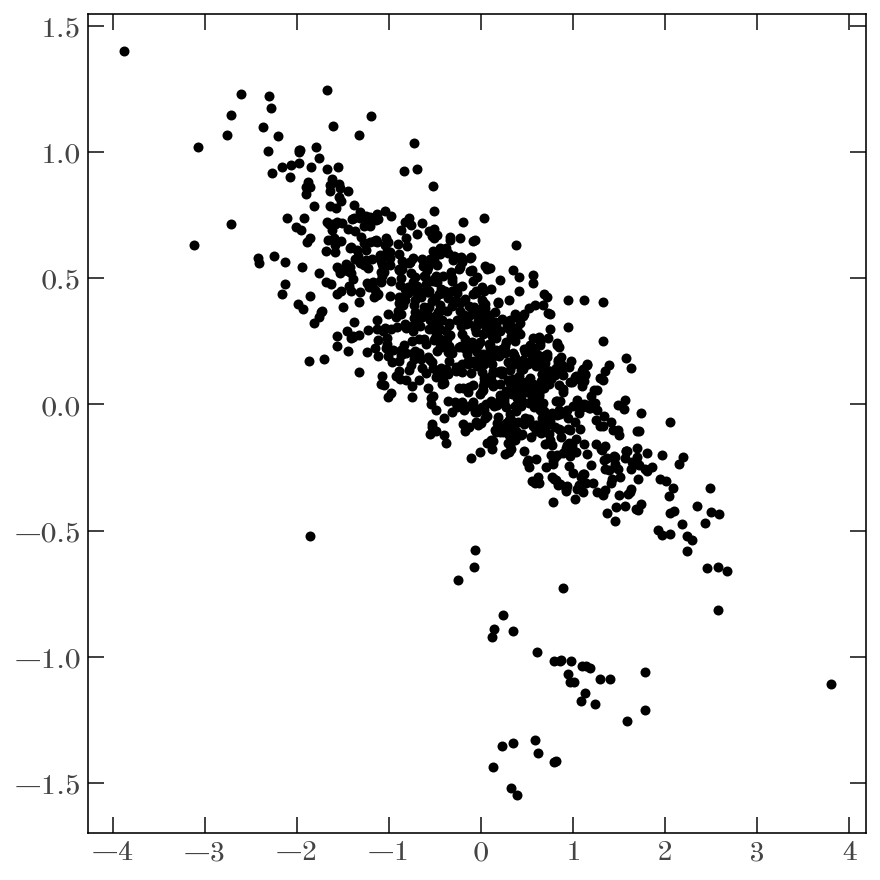

In [77]:
plt.plot(
    data_true["zeta"][:, 0],
    MAP_p["zeta"][0, :, 0],
    ls="none", marker="o"
);

TODO: need functionality to optimize for zeta given labels, fixed parameters, no flux. And also vice versa. 

In [78]:
def numpyro_model_flux(paton_model, n_stars, data, paton_params, other_params):
    zeta = numpyro.sample(
        "zeta", dist.Normal(), sample_shape=(n_stars, paton_model.n_latents),
    )
    # L1 regularization on the latents
    numpyro.factor("zeta_L1", -jnp.abs(zeta[:, paton_model.n_labels:] / 0.1).sum())

    label_unscaled, flux_unscaled = paton_model.apply(paton_params, zeta)
    model_label = other_params["a_label"] * label_unscaled + other_params["b_label"]
    model_flux = other_params["a_flux"] * flux_unscaled + other_params["b_flux"]
    numpyro.sample(
        "label", dist.Normal(model_label, data["label_err"]), obs=data["label"]
    )
    numpyro.deterministic("flux", model_flux)

In [79]:
def numpyro_model_label(paton_model, n_stars, data, paton_params, other_params):
    zeta = numpyro.sample(
        "zeta", dist.Normal(), sample_shape=(n_stars, paton_model.n_latents),
    )
    # L1 regularization on the latents
    numpyro.factor("zeta_L1", -jnp.abs(zeta[:, paton_model.n_labels:] / 0.1).sum())

    label_unscaled, flux_unscaled = paton_model.apply(paton_params, zeta)
    model_label = other_params["a_label"] * label_unscaled + other_params["b_label"]
    model_flux = other_params["a_flux"] * flux_unscaled + other_params["b_flux"]
    numpyro.sample(
        "flux", dist.Normal(model_flux, data["flux_err"]), obs=data["flux"]
    )
    numpyro.deterministic("label", model_label)

In [80]:
other_params = {
    "a_label": MAP_p["a_label"][0],
    "b_label": MAP_p["b_label"][0],
    "a_flux": MAP_p["a_flux"][0],
    "b_flux": MAP_p["b_flux"][0],
}

Try to optimize for zeta (to get labels) given only flux:

In [81]:
rng_key = jax.random.PRNGKey(1234)

optimizer = numpyro.optim.Adam(1e-3)
guide = AutoDelta(numpyro_model_label)
svi = SVI(numpyro_model_label, guide, optimizer, Trace_ELBO())
svi_results = svi.run(
    rng_key,
    20_000,
    paton_model=paton_model,
    n_stars=test_data["flux"].shape[0],
    data=test_data,
    paton_params=MAP_paton_params,
    other_params=other_params,
)

thing = Predictive(
    model=numpyro_model_label, guide=guide, params=svi_results.params, num_samples=1
)
test_MAP_p = thing(
    rng_key,
    paton_model=paton_model,
    n_stars=test_data["flux"].shape[0],
    data=test_data,
    paton_params=MAP_paton_params,
    other_params=other_params,
)
test_MAP_label = test_MAP_p["label"][0]

100%|██████████| 20000/20000 [00:06<00:00, 3325.43it/s, init loss: 108380028.4750, avg. loss [19001-20000]: 1411410.5231]


(-5.0, 5.0)

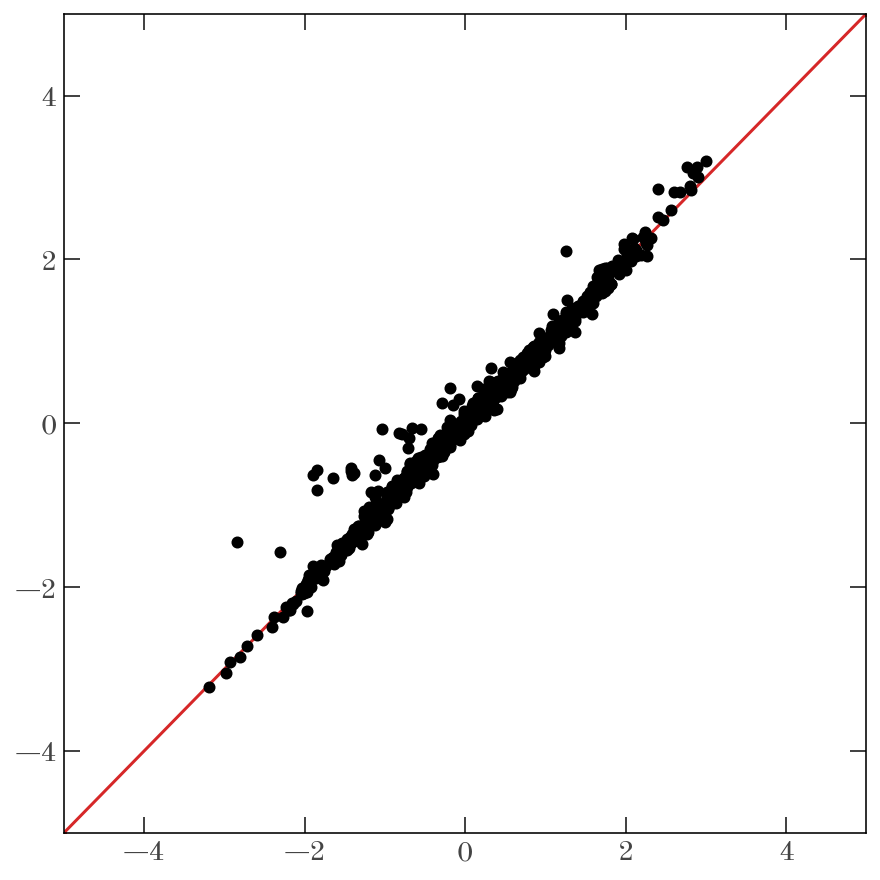

In [82]:
plt.scatter(
    test_data["label"],
    test_MAP_label
)
plt.axline([0, 0], slope=1, color="tab:red", zorder=-100)

plt.xlim(-5, 5)
plt.ylim(-5, 5)

Try to optimize for zeta (to get flux) given only label:

In [83]:
rng_key = jax.random.PRNGKey(1234)

optimizer = numpyro.optim.Adam(1e-3)
guide = AutoDelta(numpyro_model_flux)
svi = SVI(numpyro_model_flux, guide, optimizer, Trace_ELBO())
svi_results = svi.run(
    rng_key,
    100_000,
    paton_model=paton_model,
    n_stars=test_data["flux"].shape[0],
    data=test_data,
    paton_params=MAP_paton_params,
    other_params=other_params,
)

thing = Predictive(
    model=numpyro_model_flux, guide=guide, params=svi_results.params, num_samples=1
)
test_MAP_p = thing(
    rng_key,
    paton_model=paton_model,
    n_stars=test_data["flux"].shape[0],
    data=test_data,
    paton_params=MAP_paton_params,
    other_params=other_params,
)
test_MAP_flux = test_MAP_p["flux"][0]

100%|██████████| 100000/100000 [00:07<00:00, 13597.64it/s, init loss: 2148562.1593, avg. loss [95001-100000]: -150.6386]


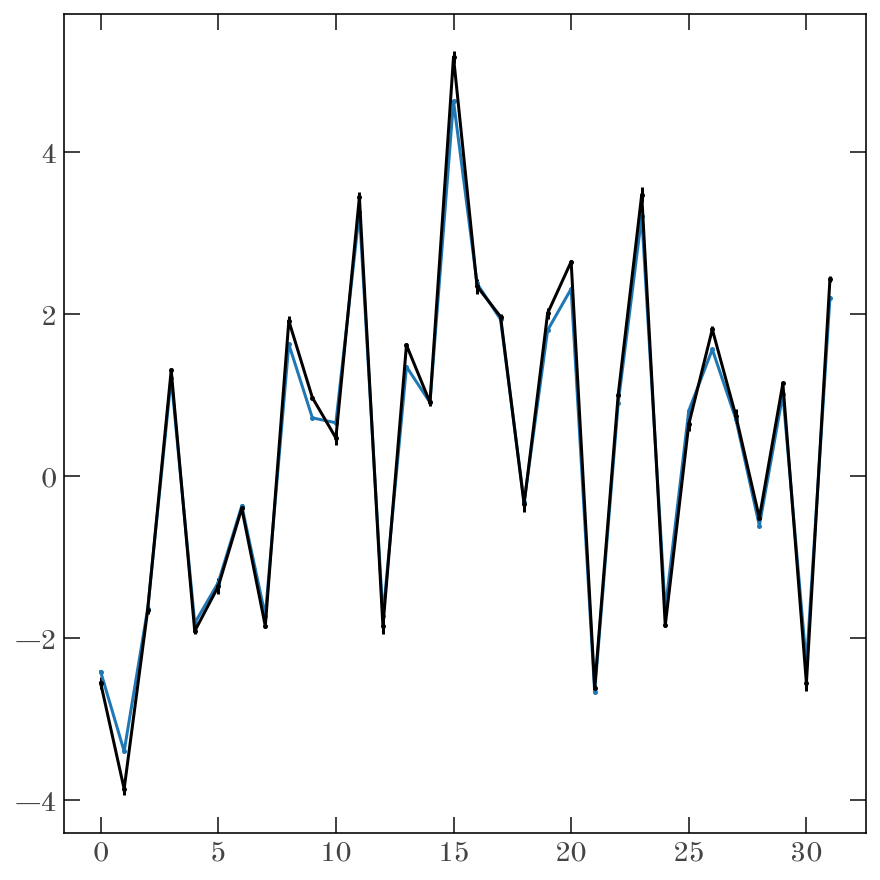

In [84]:
plt.errorbar(np.arange(test_data["flux"].shape[1]), test_data["flux"][0], test_data["flux_err"][0])
plt.plot(test_MAP_flux[0])

(-5.0, 5.0)

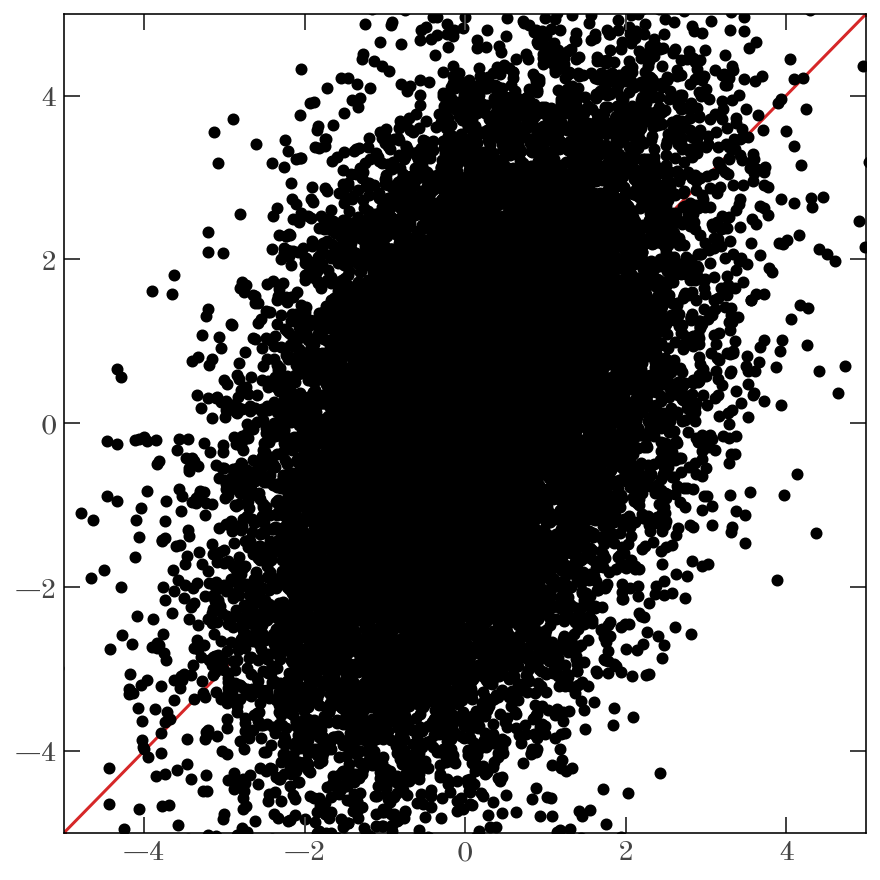

In [48]:
plt.scatter(
    test_data_true["flux"][:, 0],
    test_MAP_flux[:, 0]
)
plt.axline([0, 0], slope=1, color="tab:red", zorder=-100)

plt.xlim(-5, 5)
plt.ylim(-5, 5)